In [6]:
import sys
sys.path.append("../models/")
from model import Net
from easydict import EasyDict
import yaml
config_path = "/home/qhy/Reserach/AICAS/config/742-stage-1_3_4_1_1-ratio-0.5_0.5_1.0_0.625_0.375-op-vgg_repvgg_vgg_vgg_repvgg-pool-False_True_False_True_True_True-pool_type-None_maxpool_None_maxpool_avgpool_avgpool-cifar10.yaml"
config = EasyDict(yaml.full_load(open(config_path)))
m = Net(config,10)

# m

In [3]:
# np.save("/home/qhy/Reserach/AICAS/predictor/dataset/code.npy",np.array(code_dataset))
# np.save("/home/qhy/Reserach/AICAS/predictor/dataset/acc.npy",np.array(acc_dataset))
import numpy as np
code_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/code_510-989.npy").astype(np.float32)
acc_dataset = np.load("/home/qhy/Reserach/AICAS/predictor/dataset/acc_8_510-989.npy").astype(np.float32)


In [10]:
train_num = 300
train_code_dataset = code_dataset[0:train_num]
test_code_dataset = code_dataset[train_num:]
train_acc_dataset = acc_dataset[0:train_num]
test_acc_dataset = acc_dataset[train_num:]
print(max(train_acc_dataset))
print(max(test_acc_dataset))

92.52
92.95


In [15]:
from sklearn import metrics
import sys
import torch
sys.path.append("..")
from predictor.mlp import fit

train_num = 300
train_code_dataset = code_dataset[0:train_num]
test_code_dataset = code_dataset[train_num:]
train_acc_dataset = acc_dataset[0:train_num]
test_acc_dataset = acc_dataset[train_num:]
print(max(train_acc_dataset))
print(max(test_acc_dataset))

hyperparams = {
    "input_dims" : 21,
    "num_layers" : 5,
    "layer_width" : [ 40, 80, 40, 20, 10],
    "batch_size" : 100,
    "lr" : 0.1,
    "regularization":0.1,
    "loss": "mse" #"pair_loss" # "pair_loss" #'mae' "mse"
}
R2_test_max = -1
R2_train_max = -1

R2_SUM = -1

for num in range(10):
    train_error,model_trained = fit(hyperparams,train_code_dataset,train_acc_dataset,epochs=500,verbose=0)
    test_pred = []
    for i in test_code_dataset:
        input = torch.tensor(i).to(torch.float32)
        test_pred.append(model_trained(input).detach().numpy())
    test_acc_dataset = np.array(test_acc_dataset)
    test_pred = np.array(test_pred)
    MSE = metrics.mean_squared_error(test_acc_dataset, test_pred)
    R2_test = 1 - (MSE/np.mean((test_pred-np.mean(test_acc_dataset))**2))
    train_pred = []
    for i in train_code_dataset:
        input = torch.tensor(i)
        train_pred.append(model_trained(input).detach().numpy())
    train_acc_dataset = np.array(train_acc_dataset)
    train_pred = np.array(train_pred)
    MSE = metrics.mean_squared_error(train_acc_dataset, train_pred)
    R2_train = 1 - (MSE/np.mean((train_pred-np.mean(train_acc_dataset))**2))
    
    if R2_test_max<R2_test:
        R2_test_max = R2_test
        better_model_test = model_trained
        print(num,train_error,R2_test_max)
    if R2_train_max<R2_train:
        R2_train_max = R2_train
        better_model_train = model_trained
        print(num,train_error,R2_train_max)
    if R2_SUM <(R2_test+R2_train) :
        better_model_sum = model_trained
        R2_SUM  = R2_test+R2_train
        print(num,train_error,R2_SUM)
    # print(train_error, R2_test,R2_test_max,R2_train,R2_train_max)
    # print(train_error,R2_SUM)

92.52
92.95


100%|██████████| 500/500 [00:02<00:00, 176.84it/s]


1 16.167828 -0.3802669048309326


100%|██████████| 500/500 [00:02<00:00, 172.25it/s]


4 8.238794 -0.9669201374053955
4 8.238794 0.5726777911186218
4 8.238794 -0.3942423462867737


100%|██████████| 500/500 [00:02<00:00, 171.33it/s]


5 4.6441402 -0.5376001596450806
5 4.6441402 0.7656050324440002
5 4.6441402 0.22800487279891968


100%|██████████| 500/500 [00:02<00:00, 178.70it/s]


In [16]:
model_trained = better_model_sum

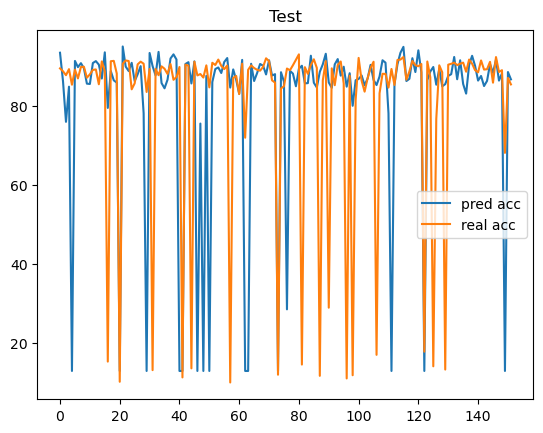

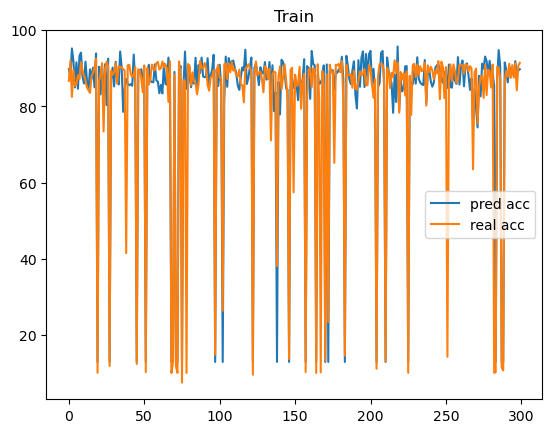

====TRAIN====
std 30.94518
mean 1.2515304
MSE 104.52701
RMSE 10.22384507201868
MAE 4.6441407
MAPE 0.15255427
R2 0.7656050324440002
spearmanr R 0.3729790881390957
spearmanr P 2.4614369996804652e-11
====TEST====
std 31.856073
mean 0.20195356
MSE 771.25885
RMSE 27.771547491950393
MAE 13.106145
MAPE 0.5121597
R2 -0.5376001596450806
spearmanr R 0.41097293522973755
spearmanr P 1.4465040844856127e-07


In [17]:
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats

test_pred = []
for i in test_code_dataset:
    input = torch.tensor(i)
    test_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(test_pred)),test_pred,label="pred acc")
plt.plot(range(len(test_pred)),test_acc_dataset,label="real acc")
plt.legend()
plt.title("Test")
plt.show()

train_pred = []
for i in train_code_dataset:
    input = torch.tensor(i)
    train_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(train_pred)),train_pred,label="pred acc")
plt.plot(range(len(train_pred)),train_acc_dataset,label="real acc")
plt.legend()
plt.title("Train")
plt.show()
print("====TRAIN====")
train_acc_dataset = np.array(train_acc_dataset)
train_pred = np.array(train_pred)
MSE = metrics.mean_squared_error(train_acc_dataset, train_pred)
RMSE = metrics.mean_squared_error(train_acc_dataset, train_pred)**0.5
MAE = metrics.mean_absolute_error(train_acc_dataset, train_pred)
MAPE = metrics.mean_absolute_percentage_error(train_acc_dataset, train_pred)
r_train,p_train = stats.spearmanr(train_acc_dataset, train_pred)
R2_train = 1 - (MSE/np.mean((train_pred-np.mean(train_acc_dataset))**2))
print("std",np.std(np.array(train_pred)-train_acc_dataset))
print("mean",np.mean(np.array(train_pred)-train_acc_dataset))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("R2",R2_train)
print("spearmanr R",r_train)
print("spearmanr P",p_train)

print("====TEST====")
test_acc_dataset = np.array(test_acc_dataset)
test_pred = np.array(test_pred)
MSE = metrics.mean_squared_error(test_acc_dataset, test_pred)
RMSE = metrics.mean_squared_error(test_acc_dataset, test_pred)**0.5
MAE = metrics.mean_absolute_error(test_acc_dataset, test_pred)
MAPE = metrics.mean_absolute_percentage_error(test_acc_dataset, test_pred)
R2_test = 1 - (MSE/np.mean((test_pred-np.mean(test_acc_dataset))**2))
r_test,p_test = stats.spearmanr(test_acc_dataset, test_pred)

print("std",np.std(np.array(test_pred)-np.array(train_acc_dataset)))
print("mean",np.mean(np.array(test_pred)-np.array(train_acc_dataset)))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("R2",R2_test)
print("spearmanr R",r_test)
print("spearmanr P",p_test)



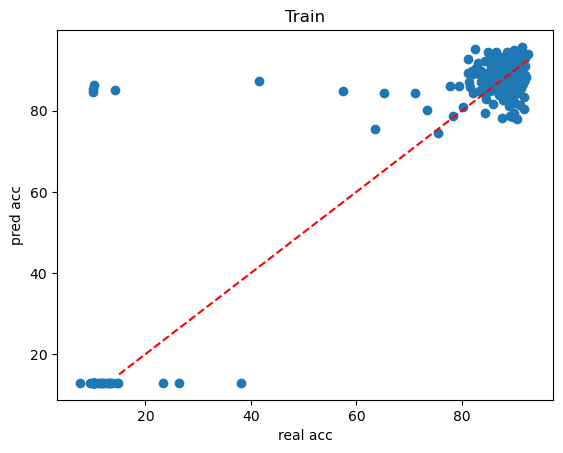

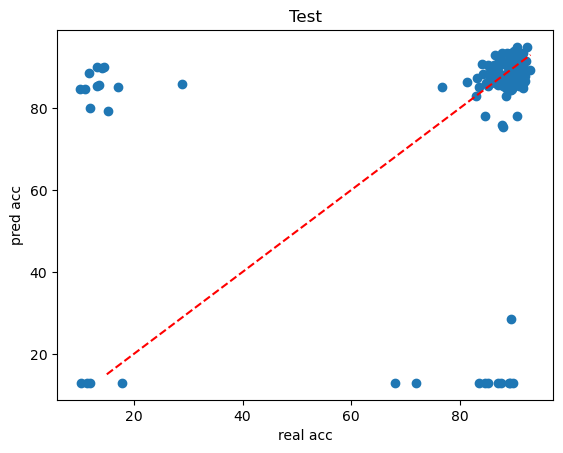

In [18]:
plt.scatter(train_acc_dataset,train_pred)
plt.plot(range(15,94),range(15,94),'--',c="r")
plt.title("Train")
plt.xlabel("real acc")
plt.ylabel("pred acc")
plt.show()
plt.scatter(test_acc_dataset,test_pred)
plt.plot(range(15,94),range(15,94),'--',c="r")
plt.title("Test")
plt.xlabel("real acc")
plt.ylabel("pred acc")
plt.show()

In [48]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, (ax0,ax1) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))
# scatter = ax0.hexbin(test_acc_dataset, test_pred.squeeze() ,bins='log',gridsize=100,cmap='Spectral_r')
# hb = ax1.hexbin(test_acc_dataset, (test_pred.squeeze()-test_acc_dataset) ,bins='log',gridsize=100,cmap='Spectral_r')

# cb = fig.colorbar(hb,ax=ax0,label="counts")
# # divider = make_axes_locatable(ax)
# # cax = divider.append_axes("right", size="5%", pad=0.1)
# # cbar = fig.colorbar(scatter, cax=cax, label='frequency')



In [8]:
import os
save_model = {
    "hyperparams":hyperparams,
    "model":model_trained.state_dict(),
    "R2-train": R2_train,
    "R2-test": R2_test,
    "R-train":r_train,
    "R-test":r_test
}
save_path = "/home/qhy/Reserach/AICAS/predictor/MLP/"+"loss-"+hyperparams['loss']+"-input_dims-"+str(hyperparams["input_dims"])+'-num_layers-'+str(hyperparams["num_layers"])+'-layer_width-'+'_'.join([str(i) for i in hyperparams["layer_width"]]) + '-lr-'+str(hyperparams['lr'])+'-regular-'+str(hyperparams['regularization'])+"-r-train-"+str(round(r_train,4))+"-r-test-"+str(round(r_test,4))+'.pth'
if os.path.exists(save_path):
    save_path = save_path.replace(".pth","-1.pth")
torch.save(save_model,save_path)

In [9]:
save_path

'/home/qhy/Reserach/AICAS/predictor/MLP/loss-mse-input_dims-21-num_layers-4-layer_width-40_30_20_10-lr-0.1-regular-0.1-r-train-0.9238-r-test-0.9443.pth'